<a href="https://colab.research.google.com/github/cdmdc/ArtPredict/blob/main/RichterPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict prices of Richter paintings using pre-trained image models (transfer learning).


---


On-going/unfinished side-project.

---
Drawing on code from this [transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.htmlhttps://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)




# Scrape images & pre-process data

In [ ]:
import numpy as np
import pandas as pd
import re
import requests
import shutil
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pickle

# from urllib.request import urlopen
from urllib.parse import urlparse, urljoin
# import urllib.request
import os
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive/')

pathname = '/content/drive/My Drive/ArtPredict/'
#pathname = '/Users/davidavinci/Documents/DAVIDAVINCI/Personal/ArtPredict/RichterPredict/data/'

Mounted at /content/drive/


In [ ]:
def download(url, pathname):
    """
    Downloads a file given an URL and puts it in the folder `pathname`
    """
    # if path doesn't exist, make that path dir
    # if not os.path.isdir(pathname):
    #     os.makedirs(pathname)
    # download the body of response by chunk, not immediately
    response = requests.get(url, stream=True)
    # get the total file size
    file_size = int(response.headers.get("Content-Length", 0))
    # get the file name
    filename = os.path.join(pathname, url.split("/")[-1])
    # progress bar, changing the unit to bytes instead of iteration (default by tqdm)
    progress = tqdm(response.iter_content(1024), f"Downloading {filename}", total=file_size, unit="B", unit_scale=True, unit_divisor=1024)
    with open(filename, "wb") as f:
        for data in progress.iterable:
            # write data read to the file
            f.write(data)
            # update the progress bar manually
            progress.update(len(data))
            
#Get data: images & price info
def getdata(url): 
    r = requests.get(url) 
    return r.text 


In [ ]:

#Loop through all pages & scrape info
npages = 135
page_start = 117
page_end = npages
nimgs_perpage = 64
for page in range(page_start,page_end+1):

  prices = []; dims = []; imgs = []
  master_url = "https://www.gerhard-richter.com/en/art/search/?p=%d&sp=%d&info=1"%(page,nimgs_perpage)
  print('CURRENT PAGE:',master_url)
  htmldata = getdata(master_url) 
  soup = BeautifulSoup(htmldata, 'html.parser')

  #Extract image-specific URLs from current page
  urls_to_follow = []
  for item in soup.find_all('a'):
      # print(item.get('href'))
      img_url = urljoin(master_url, item.get('href'))
      # print(img_url)
      if '?&info=1&p=%d&sp=%d'%(page,nimgs_perpage) in img_url:
        # print(img_url)
        urls_to_follow.append(img_url)

  #Extract images & additional info
  for url in urls_to_follow:
    htmldata = getdata(url) 
    soup = BeautifulSoup(htmldata, 'html.parser')
    for node in soup.find_all(text=lambda x: "USD" in x):
      if node:
        print('Page %d'%(page),node)
        prices.append((url,node))
      else:
        continue
    for node in soup.find_all(text=lambda x: "cm x" in x):
      if node:
        print('Page %d'%(page),node)
        dims.append((url,node))
      else: 
        continue
    for item in soup.find_all(['img']):
        img_url = item["src"]
        if img_url and ('xxlarge' in img_url):
          full_url = urljoin(master_url, img_url)
          print('Page %d'%(page),full_url)
          imgs.append((url,full_url))
          # download(full_url,pathname+'images/')
        else:
          continue

  #Checkpoint save vars after current page
  np.savez(pathname+'additional_info_page%d.npz'%(page),imgs=np.array(imgs),
           prices = np.array(prices),dims = np.array(dims))


CURRENT PAGE: https://www.gerhard-richter.com/en/art/search/?p=117&sp=64&info=1
Page 117 
18.6 cm x 12.6 cm
Page 117 USD 37,004 –  49,339
Page 117 USD 67,620 –  101,431
Page 117 USD 19,760
Page 117 
USD 18,665
Page 117 
18.6 cm x 12.6 cm
Page 117 https://www.gerhard-richter.com/datadir/images_new/xxlarge/22022.jpg
Page 117 
18.6 cm x 12.6 cm
Page 117 
18.6 cm x 12.6 cm
Page 117 
18.6 cm x 12.6 cm


KeyboardInterrupt: ignored

In [ ]:
# print(prices)
# print(dims)
# print(imgs)
print('Num price entries:',len(prices))
print('Num dims entries:',len(dims))
print('Num imgs entries:',len(imgs))

[('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/turned-sheets-60/turned-sheet-15985/?&info=1&p=1&sp=64', 'USD 724,470 –  965,960'), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/household-icons-39/table-4954/?&info=1&p=1&sp=64', 'USD 334,784 –  502,176'), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/household-icons-39/table-4954/?&info=1&p=1&sp=64', '\nUSD 415,207'), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/women-27/skater-5471/?&info=1&p=1&sp=64', 'USD 3,307,600 –  4,961,400'), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/women-27/skater-5471/?&info=1&p=1&sp=64', '\nUSD 3,845,813'), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/death-9/dead-5263/?&info=1&p=1&sp=64', 'USD 935,000 –  1,250,000'), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/death-9/dead-5263/?&info=1&p=1&sp=64', '\nUSD 928,736'), ('https://www.gerhard-richter.com/en/ar

In [ ]:
#Clean up labels & features

imgs_all = []
prices_all = []
dims_all = []
npages = 135
for page in range(1,npages+1):#npages+1
  data = np.load(pathname+'additional_info_page%d.npz'%(page))
  for entry in data['imgs']:
    curr_img_id = re.findall(r'\d+.jpg',entry[1])
    print('Current Page %d |'%(page),curr_img_id)
    if len(curr_img_id)!=0:
      imgs_all.append((entry[0],curr_img_id[0]))
  for entry in data['prices']:
    curr_prices = re.findall(r'\d+,\d+',entry[1])
    curr_prices_int = [np.int(re.sub(",","",item)) for item in curr_prices]
    print('Current Page %d |'%(page),curr_prices_int)
    if len(curr_prices_int)!=0:
      prices_all.append((entry[0],np.mean(curr_prices_int)))#Get the mean of prices
  for entry in data['dims']:
    curr_dims = test = re.findall(r'\d+[.\d+]* cm',entry[1])
    curr_dims_int = [np.float(re.sub("[.]* cm","",item)) for item in curr_dims]
    print('Current Page %d |'%(page),curr_dims_int)
    len_dims = len(curr_dims_int)
    if len_dims==1:
      dims_all.append((entry[0],curr_dims_int[0],0,0))
    elif len_dims==2:
      dims_all.append((entry[0],curr_dims_int[0],curr_dims_int[1],0))
    elif len_dims==3:
      dims_all.append((entry[0],curr_dims_int[0],curr_dims_int[1],curr_dims_int[2]))
    else:
      continue #Exclude if =0 or 4D

#Convert to dataframe
imgs_all = pd.DataFrame(imgs_all,columns=['URL','img_id'])
prices_all = pd.DataFrame(prices_all,columns=['URL','price'])
dims_all = pd.DataFrame(dims_all,columns=['URL','dim1','dim2','dim3'])

Streaming output truncated to the last 5000 lines.
Current Page 97 | [10.0, 15.0]
Current Page 97 | [10.2, 15.2]
Current Page 97 | [10.0, 15.0]
Current Page 97 | [10.0, 15.0]
Current Page 97 | [10.5]
Current Page 97 | [10.0, 15.0]
Current Page 97 | [10.0, 15.0]
Current Page 97 | [10.0, 15.0]
Current Page 97 | [10.5, 15.0]
Current Page 97 | [10.0, 15.0]
Current Page 97 | [10.1, 14.7]
Current Page 97 | [10.0, 15.0]
Current Page 97 | [10.0, 15.0]
Current Page 97 | [14.9, 10.1]
Current Page 97 | [10.0, 15.0]
Current Page 97 | [9.8, 15.2]
Current Page 97 | [9.8, 15.0]
Current Page 97 | [9.5, 15.0]
Current Page 97 | [14.5, 10.1]
Current Page 97 | [14.7, 10.0]
Current Page 97 | [8.9, 12.7]
Current Page 97 | [11.9, 18.6]
Current Page 97 | [12.7, 17.7]
Current Page 97 | [12.0, 18.4]
Current Page 97 | [14.9, 10.2]
Current Page 97 | [12.0, 18.4]
Current Page 97 | [10.1, 14.7]
Current Page 97 | [18.0, 12.7]
Current Page 97 | [18.0, 12.7]
Current Page 97 | [17.7, 12.5]
Current Page 97 | [9.6, 14.8]

# Make sure data looks good / get price bins / save

In [ ]:

#Plot
imgs_all.head()
# prices_all.head()
# dims_all.head()

# # Join on link
all_info = pd.merge(imgs_all,prices_all, on=['URL'])
all_info = pd.merge(all_info,dims_all,on=['URL'])
all_info.head()
print('Number images with info: %d'%(np.size(all_info)))

#Save dataframe
all_info.to_pickle(pathname+'all_info_clean')


targets = all_info[['img_id','price']]
targets.head()

sup_info = all_info[['img_id','dim1','dim2','dim3']]
sup_info.head()

#Save sa CSV
targets.to_csv(pathname+'targets.csv',header=False,index=False)
sup_info.to_csv(pathname+'sup_info.csv',header=False,index=False)

Number images with info: 23028


In [ ]:
print(imgs_all)
print(prices_all)
print(dims_all)

[('https://www.gerhard-richter.com/en/art/other/glass-and-mirrors-105/mirror-18461/?&info=1&p=1&sp=64', ['21854.jpg']), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/turned-sheets-60/turned-sheet-15985/?&info=1&p=1&sp=64', ['10375.jpg']), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/household-icons-39/table-4954/?&info=1&p=1&sp=64', ['2307.jpg']), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/women-27/skater-5471/?&info=1&p=1&sp=64', ['2430.jpg']), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/everyday-life-18/party-6367/?&info=1&p=1&sp=64', ['3215.jpg']), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/death-9/hitler-5472/?&info=1&p=1&sp=64', ['14706.jpg']), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/household-icons-39/folding-dryer-5473/?&info=1&p=1&sp=64', ['8768.jpg']), ('https://www.gerhard-richter.com/en/art/paintings/photo-paintings/death-9/coffin-beare

0       (279400.0, 998946.0]
1       (279400.0, 998946.0]
2       (279400.0, 998946.0]
3         (1003.999, 5453.6]
4         (1003.999, 5453.6]
                ...         
3833     (68763.2, 279400.0]
3834     (68763.2, 279400.0]
3835     (68763.2, 279400.0]
3836     (68763.2, 279400.0]
3837     (68763.2, 279400.0]
Name: price, Length: 3838, dtype: category
Categories (5, interval[float64]): [(1003.999, 5453.6] < (5453.6, 23070.2] < (23070.2, 68763.2] <
                                    (68763.2, 279400.0] < (279400.0, 998946.0]]

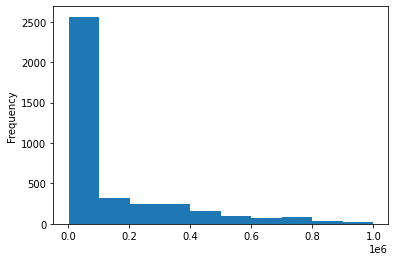

In [ ]:
#Read data back in and plot histogram of prices
data = pd.read_pickle(pathname+'all_info_clean')
ax = data['price'].plot.hist(bins=10,alpha = 1)

In [ ]:
#Bin price data for prediction & save
data['price_5bins'] = pd.qcut(data['price'],5,labels=np.arange(5))
data['price_10bins'] = pd.qcut(data['price'],10,labels=np.arange(10))
data['price_20bins'] = pd.qcut(data['price'],20,labels=np.arange(20))
data['price_5bins'].head()
data.to_pickle(pathname+'all_info_binned')

# Set up data loaders & model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.io import read_image
from torchvision.utils import make_grid
from PIL import Image
import time
import copy

In [ ]:
class LoadData(Dataset):

    def __init__(self, pickle_file, image_dir, transform=None,target_transform=None):
        self.image_dir = image_dir
        self.pickle_file = pickle_file
        self.tabular = pd.read_pickle(pickle_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tabular = self.tabular.iloc[idx, 0:]

        label = tabular["price_5bins"]
        label = np.expand_dims(label,axis=0)
        label = np.array(label,dtype=np.int)

        # label = np.expand_dims(label,axis=1)

        # img_path = os.path.join(self.image_dir,tabular['img_id'])
        # image = read_image(img_path)
        image = Image.open(f"{self.image_dir}{tabular['img_id']}")
        image = np.array(image)
        image = image[...,:3]
        image = transforms.functional.to_tensor(image)
        # image = image.to(torch.float64)
 
        #Apply transforms, if any
        if self.transform:
          image = self.transform(image)
        if self.target_transform:
          label = self.target_transform(label)

        tabular_input = tabular[['dim1','dim2','dim3']]
        tabular_input = tabular_input.tolist()
        tabular_input = torch.FloatTensor(tabular_input)

        #Skip tabular_input for now
        return image, label #include tabular_input here if desired

In [ ]:
from torch.utils.data import DataLoader

#Define train params
batch_size = 5
input_size = 224

def setup_model():

  data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
  }

  img_data = {x: LoadData(pickle_file=f"{pathname}all_info_binned", 
                          image_dir=f"{pathname}images/",
                          transform=data_transforms[x]) for x in ['train', 'val','test']}
  # img_data = LoadData(pickle_file=f"{pathname}all_info_clean", image_dir=f"{pathname}images/",
  #                     transform=transforms.Compose([transforms.Resize((224,224)),
  #                                                   transforms.RandomHorizontalFlip(),
  #                                                   transforms.ToTensor(),
  #                                                   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
  
  dataloaders = {x: DataLoader(img_data[x], batch_size=batch_size, 
                                    shuffle=True, num_workers=2) for x in ['train', 'val','test']}
  # img_data_length = len(img_data)
  # train_size = int(0.80 * img_data_length)
  # val_size = int((img_data_length - train_size) / 2)
  # test_size = int((img_data_length - train_size) / 2)

  # train_set, val_set, test_set = random_split(img_data, (train_size, val_size, test_size))

  # train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
  # test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=True)
  # val_dataloader = DataLoader(val_set,batch_size=batch_size,shuffle=True)
  # dataloaders = {'train':train_dataloader,'test':test_dataloader,'val':val_dataloader}
  # dataset_size = {'train':train_size,'test':test_size,'val':val_size}

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  return dataloaders,device


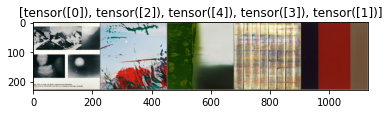

In [ ]:
dataloaders,device = setup_model()

#Visualize some images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, labels = next(iter(dataloaders['test']))

# Make a grid from batch
out = make_grid(images)

imshow(out, title=[x for x in labels])

# train_features, tabular_train_features, train_labels = next(iter(dataloaders['train']))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[1].squeeze()
# img = img.numpy().transpose((1, 2, 0))
# label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.show()
# print(f"Label: {label}")

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# def visualize_model(model, num_images=6):
#     was_training = model.training
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure()

#     with torch.no_grad():
#         for i, (inputs, tabular_inputs, labels) in enumerate(dataloaders['val']):
#             inputs = inputs.to(device)
#             tabular_inputs = tabular_inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)

#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         model.train(mode=was_training)

In [ ]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Extract pre-trained layers
# model_pruned = nn.Sequential(*(list(model.children())[:-2]))
# model_pruned

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
#Feature extract. If False, finetune whole model. If True, only update new layer(s).
feature_extract = True
set_parameter_requires_grad(model, feature_extract)

#Add new layer on top
num_ftrs = model.fc.in_features
num_classes_to_predict = 5
model.fc = nn.Linear(num_ftrs,num_classes_to_predict,bias=True)


In [ ]:
model = model.to(device)

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

criterion = nn.L1Loss()

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
num_epochs = 10
model, hist = train_model(model, dataloaders, criterion, optimizer, 
                          num_epochs=num_epochs)
# for epoch in range(10):
#   train(model, device, dataloaders['train'], optimizer, criterion, epoch, steps_per_epoch=10)

Epoch 0/99
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


train Loss: 1.5554 Acc: 0.9745


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


val Loss: 1.4161 Acc: 0.9591

Epoch 1/99
----------
train Loss: 1.6247 Acc: 1.0076
val Loss: 1.5245 Acc: 0.9948

Epoch 2/99
----------
train Loss: 1.5654 Acc: 0.9789
val Loss: 1.9677 Acc: 1.0003

Epoch 3/99
----------
train Loss: 1.5516 Acc: 1.0440
val Loss: 1.5674 Acc: 0.9935

Epoch 4/99
----------
train Loss: 1.5696 Acc: 0.9463
val Loss: 1.3941 Acc: 0.9745

Epoch 5/99
----------


KeyboardInterrupt: ignored

# Look at some predictions from the trained model

In [ ]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, actual: {}'.format(class_names[preds[j]],
                                                                class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

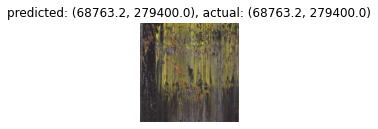

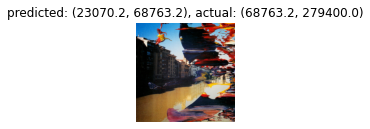

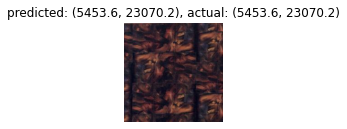

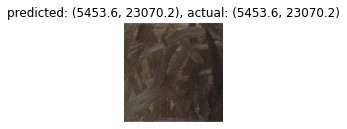

In [ ]:
class_names = [(1003.999, 5453.6),(5453.6, 23070.2),(23070.2, 68763.2),
(68763.2, 279400.0),(279400.0, 998946.0)]
visualize_model(model)